Preprocessing: Actually the feature input used in this model is generated by other notebooks. There exists some models using the same data input to reduce unnecessary duplication of work. After all, we aim to evaluate whether the structure of model is useful for classification.

This is code from other notebooks.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
import os,glob,skimage,librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")    
root="/content/drive/MyDrive/Thesis_Keras/"        
csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
examplePath = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold6/85249-2-0-79.wav'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import random
import keras
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm._tqdm import trange
from keras.utils import np_utils

def readFromCsv(csvpth):
    # 生成数据列表
    # 读取wav文件函数
    #data = pd.read_csv('metadata/UrbanSound8K.csv')
    data = pd.read_csv(csvpth)
    valid_data = data[['slice_file_name', 'fold', 'classID', 'class']][data['end'] - data['start'] >= 2]
    valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
        'str')
    return valid_data


def splitData(current):
  
  D=[]
  i=1

  for row in tqdm(current.itertuples(),total=current.shape[0]):
        #print(row.path)
        #print(row.classID)
        #print(f"{i} out of {len(current)}")
        X, sample_rate = librosa.load("/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/" + row.path, res_type='kaiser_fast', duration=2.97)


        mels = librosa.feature.melspectrogram(X, sr=sample_rate,n_mels=40)

        if mels.shape != (40, 128): 
          continue
        feature = mels
        label = row.classID
        D.append((feature,label))
  dataset = D
  X,y=zip(*dataset)
  
  print("type of X is:",type(X))
  y=np.array(y).astype(np.int64)
  y = np.array(np_utils.to_categorical(y, 10))

  return  X,y


def save_npy(nparr,modelName,featureName,subDataset,fold):
    import os
    dirs = "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy"+'/'+modelName+'/'+featureName+'/'+fold
    
    #Create a directory to place the dataset npy files.
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        print(f"Created directory:{dirs}")
    
    subDataset+='.npy'
    print(subDataset)
    subsetPth=os.path.join(dirs,subDataset)
    #with open(subsetPth, 'w') as f:
    np.save(subsetPth, nparr)
    print(f"save {subDataset} done")
    print(f"Path:{subsetPth}")

def Ten_fold():
    csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
    #df=pd.read_csv(csvPth)
    valid_data=readFromCsv(csvPth)
    #valid_data = df[['slice_file_name', 'fold', 'classID', 'class']][df['end'] - df['start']]
    # valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
    #     'str')
    for i in range(10):#Folder : "fold1" to "fold10"
        print(f"fold:{i+1} out of 10")
        current=valid_data[valid_data['fold'] == i+1]
        X,y = splitData(current)
        print("Dataset split done!")
        print("Saving subsets to .npy files!")
        
        save_npy(X, 'MelConv1', 'mel', 'X',f"fold{i+1}")
        save_npy(y, 'MelConv1', 'mel', 'y',f"fold{i+1}")

In [ ]:
Ten_fold() # generate 10-fold training and test data packed in .npy files. Easier to be used in later experiments.

10-fold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
from tqdm import tqdm
def generate_loader(i_val):
    train_X = []
    train_y=[]
    X_test=[]
    y_test=[]
    for i in range(10):
        if i + 1 == i_val:
            X_test = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/X.npy"
                )
            y_test=np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/y.npy"
            )
        else:
            X_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/X.npy"
            )
            y_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/MelConv1/mel/"+f"fold{i + 1}"+"/y.npy"
            )

            for item in X_train:
                train_X.append(item)
            for item in y_train:
                train_y.append(item)

    return np.array(train_X),np.array(train_y),np.array(X_test),np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,AveragePooling1D,AveragePooling2D
from tensorflow.keras.optimizers import Adam


def build_model(input_length):
    # model = Sequential()
    # model.add(Reshape((128,40), input_shape=(input_length,128)))
    # model.add(Conv1D(32, kernel_size=5, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
    # model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    # model.add(Conv1D(24, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
    # model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    # model.add(Conv1D(24, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
    # model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    # model.add(Dropout(0.4))
    # model.add(Flatten())
    # model.add(Dense(10, activation='softmax', name='y_pred'))
    model = Sequential()
    model.add(Reshape((128,40), input_shape=(40,128 )))
    model.add(Conv1D(12, kernel_size=5, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Conv1D(28, kernel_size=5, activation='relu', padding='valid'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax', name='y_pred'))
    return model

def train_model(model,X_train,Y_train,X_test,Y_test,foldNum):
  EPOCHS = 100
  # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
  BATCH_SIZE = 32
  callbacks = []
  # model architecture
  
  # this controls the learning rate
  opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
  #callbacks.append(BatchLoggerCallback(BATCH_SIZE, train_sample_count, epochs=EPOCHS))

  # train the neural network
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2,validation_split=0.1,shuffle=True)
  print(model.summary())
  # Use this flag to disable per-channel quantization for a model.
  # This can reduce RAM usage for convolutional models, but may have
  # an impact on accuracy.
  disable_per_channel_quantization = False
  print("Result of fold:"+f"{foldNum}")
  score = model.evaluate(
        x=X_test,
        y=Y_test)

In [ ]:
for i in tqdm(range(10)):
  #from tensorflow.compat.v1.keras import backend as K
  import tensorflow as tf

  import os

  X_train,y_train,X_test,y_test = generate_loader(i+1)


  input_len=len(X_train[0])
  model = build_model(input_len)
  if not i==0:
    model = build_model(input_len)
  
  train_model(model,X_train,y_train,X_test,y_test,i+1)
  model.save("/content/drive/MyDrive/Thesis_Keras/"+"model/saved/Lhoest"+f"fold{i+1}"+".h5")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100
190/190 - 13s - loss: 2.2458 - accuracy: 0.2740 - val_loss: 1.9231 - val_accuracy: 0.2511 - 13s/epoch - 71ms/step
Epoch 2/100
190/190 - 1s - loss: 1.7353 - accuracy: 0.3747 - val_loss: 1.7020 - val_accuracy: 0.4324 - 681ms/epoch - 4ms/step
Epoch 3/100
190/190 - 1s - loss: 1.6661 - accuracy: 0.3980 - val_loss: 1.7615 - val_accuracy: 0.2660 - 669ms/epoch - 4ms/step
Epoch 4/100
190/190 - 1s - loss: 1.5781 - accuracy: 0.4448 - val_loss: 1.6527 - val_accuracy: 0.4309 - 677ms/epoch - 4ms/step
Epoch 5/100
190/190 - 1s - loss: 1.5328 - accuracy: 0.4673 - val_loss: 1.6986 - val_accuracy: 0.4517 - 676ms/epoch - 4ms/step
Epoch 6/100
190/190 - 1s - loss: 1.4752 - accuracy: 0.4878 - val_loss: 1.7257 - val_accuracy: 0.3269 - 672ms/epoch - 4ms/step
Epoch 7/100
190/190 - 1s - loss: 1.4577 - accuracy: 0.4992 - val_loss: 1.6204 - val_accuracy: 0.4235 - 675ms/epoch - 4ms/step
Epoch 8/100
190/190 - 1s - loss: 1.4289 - accuracy: 0.5073 - val_loss: 1.6059 - val_accuracy: 0.4324 - 681ms/epoch - 4

 10%|█         | 1/10 [01:22<12:24, 82.70s/it]

Epoch 1/100
190/190 - 2s - loss: 2.3361 - accuracy: 0.2629 - val_loss: 1.9859 - val_accuracy: 0.3131 - 2s/epoch - 8ms/step
Epoch 2/100
190/190 - 1s - loss: 1.7791 - accuracy: 0.3629 - val_loss: 1.7525 - val_accuracy: 0.3338 - 668ms/epoch - 4ms/step
Epoch 3/100
190/190 - 1s - loss: 1.6390 - accuracy: 0.4171 - val_loss: 1.6981 - val_accuracy: 0.4466 - 676ms/epoch - 4ms/step
Epoch 4/100
190/190 - 1s - loss: 1.5871 - accuracy: 0.4349 - val_loss: 1.6827 - val_accuracy: 0.3591 - 681ms/epoch - 4ms/step
Epoch 5/100
190/190 - 1s - loss: 1.5454 - accuracy: 0.4611 - val_loss: 1.5122 - val_accuracy: 0.4926 - 686ms/epoch - 4ms/step
Epoch 6/100
190/190 - 1s - loss: 1.4656 - accuracy: 0.4875 - val_loss: 1.6017 - val_accuracy: 0.3783 - 674ms/epoch - 4ms/step
Epoch 7/100
190/190 - 1s - loss: 1.5256 - accuracy: 0.4770 - val_loss: 1.6325 - val_accuracy: 0.3412 - 684ms/epoch - 4ms/step
Epoch 8/100
190/190 - 1s - loss: 1.4252 - accuracy: 0.5026 - val_loss: 1.6488 - val_accuracy: 0.4570 - 668ms/epoch - 4ms/

 20%|██        | 2/10 [02:33<10:03, 75.48s/it]

Epoch 1/100
188/188 - 2s - loss: 2.1910 - accuracy: 0.2824 - val_loss: 1.6982 - val_accuracy: 0.4063 - 2s/epoch - 8ms/step
Epoch 2/100
188/188 - 1s - loss: 1.7049 - accuracy: 0.3761 - val_loss: 1.6377 - val_accuracy: 0.3823 - 661ms/epoch - 4ms/step
Epoch 3/100
188/188 - 1s - loss: 1.6117 - accuracy: 0.4186 - val_loss: 1.6762 - val_accuracy: 0.3673 - 673ms/epoch - 4ms/step
Epoch 4/100
188/188 - 1s - loss: 1.6214 - accuracy: 0.4101 - val_loss: 1.6969 - val_accuracy: 0.4078 - 654ms/epoch - 3ms/step
Epoch 5/100
188/188 - 1s - loss: 1.5163 - accuracy: 0.4640 - val_loss: 1.5941 - val_accuracy: 0.4708 - 663ms/epoch - 4ms/step
Epoch 6/100
188/188 - 1s - loss: 1.4499 - accuracy: 0.4942 - val_loss: 1.5543 - val_accuracy: 0.4843 - 668ms/epoch - 4ms/step
Epoch 7/100
188/188 - 1s - loss: 1.4274 - accuracy: 0.4995 - val_loss: 1.6416 - val_accuracy: 0.4438 - 679ms/epoch - 4ms/step
Epoch 8/100
188/188 - 1s - loss: 1.4132 - accuracy: 0.5135 - val_loss: 1.6902 - val_accuracy: 0.4123 - 659ms/epoch - 4ms/

 30%|███       | 3/10 [03:41<08:27, 72.44s/it]

Epoch 1/100
188/188 - 1s - loss: 2.2403 - accuracy: 0.2718 - val_loss: 1.8226 - val_accuracy: 0.3153 - 1s/epoch - 8ms/step
Epoch 2/100
188/188 - 1s - loss: 1.7244 - accuracy: 0.3703 - val_loss: 1.6066 - val_accuracy: 0.4204 - 698ms/epoch - 4ms/step
Epoch 3/100
188/188 - 1s - loss: 1.6246 - accuracy: 0.4189 - val_loss: 1.6510 - val_accuracy: 0.4985 - 669ms/epoch - 4ms/step
Epoch 4/100
188/188 - 1s - loss: 1.5479 - accuracy: 0.4321 - val_loss: 1.5640 - val_accuracy: 0.4565 - 661ms/epoch - 4ms/step
Epoch 5/100
188/188 - 1s - loss: 1.5421 - accuracy: 0.4553 - val_loss: 2.0907 - val_accuracy: 0.3288 - 671ms/epoch - 4ms/step
Epoch 6/100
188/188 - 1s - loss: 1.4772 - accuracy: 0.4864 - val_loss: 1.5686 - val_accuracy: 0.5135 - 671ms/epoch - 4ms/step
Epoch 7/100
188/188 - 1s - loss: 1.4285 - accuracy: 0.5023 - val_loss: 1.6744 - val_accuracy: 0.4204 - 665ms/epoch - 4ms/step
Epoch 8/100
188/188 - 1s - loss: 1.4431 - accuracy: 0.5003 - val_loss: 1.6117 - val_accuracy: 0.4339 - 664ms/epoch - 4ms/

 40%|████      | 4/10 [04:50<07:05, 71.00s/it]

Epoch 1/100
189/189 - 2s - loss: 2.1739 - accuracy: 0.2916 - val_loss: 1.7259 - val_accuracy: 0.4230 - 2s/epoch - 8ms/step
Epoch 2/100
189/189 - 1s - loss: 1.6443 - accuracy: 0.4160 - val_loss: 1.7005 - val_accuracy: 0.3662 - 667ms/epoch - 4ms/step
Epoch 3/100
189/189 - 1s - loss: 1.5306 - accuracy: 0.4687 - val_loss: 1.6521 - val_accuracy: 0.3722 - 667ms/epoch - 4ms/step
Epoch 4/100
189/189 - 1s - loss: 1.4413 - accuracy: 0.4994 - val_loss: 1.6752 - val_accuracy: 0.3707 - 655ms/epoch - 3ms/step
Epoch 5/100
189/189 - 1s - loss: 1.3633 - accuracy: 0.5380 - val_loss: 1.6183 - val_accuracy: 0.4096 - 659ms/epoch - 3ms/step
Epoch 6/100
189/189 - 1s - loss: 1.3506 - accuracy: 0.5499 - val_loss: 1.5396 - val_accuracy: 0.5007 - 671ms/epoch - 4ms/step
Epoch 7/100
189/189 - 1s - loss: 1.3051 - accuracy: 0.5652 - val_loss: 1.6741 - val_accuracy: 0.4439 - 656ms/epoch - 3ms/step
Epoch 8/100
189/189 - 1s - loss: 1.3234 - accuracy: 0.5537 - val_loss: 1.7335 - val_accuracy: 0.4350 - 667ms/epoch - 4ms/

 50%|█████     | 5/10 [05:59<05:50, 70.05s/it]

Epoch 1/100
191/191 - 2s - loss: 2.2463 - accuracy: 0.2652 - val_loss: 1.8254 - val_accuracy: 0.3717 - 2s/epoch - 8ms/step
Epoch 2/100
191/191 - 1s - loss: 1.7485 - accuracy: 0.3694 - val_loss: 1.7148 - val_accuracy: 0.3820 - 680ms/epoch - 4ms/step
Epoch 3/100
191/191 - 1s - loss: 1.5850 - accuracy: 0.4327 - val_loss: 1.6025 - val_accuracy: 0.4779 - 684ms/epoch - 4ms/step
Epoch 4/100
191/191 - 1s - loss: 1.5685 - accuracy: 0.4577 - val_loss: 1.6860 - val_accuracy: 0.3953 - 683ms/epoch - 4ms/step
Epoch 5/100
191/191 - 1s - loss: 1.4575 - accuracy: 0.4831 - val_loss: 1.5785 - val_accuracy: 0.5044 - 695ms/epoch - 4ms/step
Epoch 6/100
191/191 - 1s - loss: 1.4525 - accuracy: 0.5021 - val_loss: 1.6319 - val_accuracy: 0.4587 - 685ms/epoch - 4ms/step
Epoch 7/100
191/191 - 1s - loss: 1.3841 - accuracy: 0.5251 - val_loss: 1.5711 - val_accuracy: 0.4720 - 669ms/epoch - 4ms/step
Epoch 8/100
191/191 - 1s - loss: 1.3409 - accuracy: 0.5404 - val_loss: 1.6305 - val_accuracy: 0.4543 - 671ms/epoch - 4ms/

 60%|██████    | 6/10 [07:08<04:39, 69.91s/it]

Epoch 1/100
190/190 - 2s - loss: 2.1107 - accuracy: 0.2784 - val_loss: 1.8667 - val_accuracy: 0.3378 - 2s/epoch - 8ms/step
Epoch 2/100
190/190 - 1s - loss: 1.7868 - accuracy: 0.3501 - val_loss: 1.7638 - val_accuracy: 0.3793 - 679ms/epoch - 4ms/step
Epoch 3/100
190/190 - 1s - loss: 1.6959 - accuracy: 0.3964 - val_loss: 1.6934 - val_accuracy: 0.3733 - 667ms/epoch - 4ms/step
Epoch 4/100
190/190 - 1s - loss: 1.5556 - accuracy: 0.4524 - val_loss: 1.5632 - val_accuracy: 0.4711 - 671ms/epoch - 4ms/step
Epoch 5/100
190/190 - 1s - loss: 1.5140 - accuracy: 0.4694 - val_loss: 1.6468 - val_accuracy: 0.4178 - 657ms/epoch - 3ms/step
Epoch 6/100
190/190 - 1s - loss: 1.4642 - accuracy: 0.4919 - val_loss: 1.6142 - val_accuracy: 0.4519 - 666ms/epoch - 4ms/step
Epoch 7/100
190/190 - 1s - loss: 1.4451 - accuracy: 0.5133 - val_loss: 1.6835 - val_accuracy: 0.4163 - 669ms/epoch - 4ms/step
Epoch 8/100
190/190 - 1s - loss: 1.3643 - accuracy: 0.5417 - val_loss: 1.6276 - val_accuracy: 0.4400 - 671ms/epoch - 4ms/

 70%|███████   | 7/10 [08:17<03:28, 69.57s/it]

Epoch 1/100
192/192 - 1s - loss: 2.3059 - accuracy: 0.2542 - val_loss: 1.8616 - val_accuracy: 0.3162 - 1s/epoch - 7ms/step
Epoch 2/100
192/192 - 1s - loss: 1.7662 - accuracy: 0.3719 - val_loss: 1.7324 - val_accuracy: 0.3574 - 666ms/epoch - 3ms/step
Epoch 3/100
192/192 - 1s - loss: 1.6541 - accuracy: 0.4066 - val_loss: 1.6683 - val_accuracy: 0.3485 - 694ms/epoch - 4ms/step
Epoch 4/100
192/192 - 1s - loss: 1.5887 - accuracy: 0.4230 - val_loss: 1.7645 - val_accuracy: 0.3044 - 676ms/epoch - 4ms/step
Epoch 5/100
192/192 - 1s - loss: 1.5193 - accuracy: 0.4516 - val_loss: 1.6344 - val_accuracy: 0.3926 - 673ms/epoch - 4ms/step
Epoch 6/100
192/192 - 1s - loss: 1.5058 - accuracy: 0.4702 - val_loss: 1.6384 - val_accuracy: 0.3412 - 681ms/epoch - 4ms/step
Epoch 7/100
192/192 - 1s - loss: 1.5144 - accuracy: 0.4639 - val_loss: 1.6296 - val_accuracy: 0.4162 - 662ms/epoch - 3ms/step
Epoch 8/100
192/192 - 1s - loss: 1.4706 - accuracy: 0.4738 - val_loss: 1.7883 - val_accuracy: 0.3750 - 681ms/epoch - 4ms/

 80%|████████  | 8/10 [09:27<02:19, 69.65s/it]

Epoch 1/100
191/191 - 1s - loss: 2.2439 - accuracy: 0.2953 - val_loss: 1.8571 - val_accuracy: 0.2437 - 1s/epoch - 8ms/step
Epoch 2/100
191/191 - 1s - loss: 1.6986 - accuracy: 0.3893 - val_loss: 1.7265 - val_accuracy: 0.3619 - 670ms/epoch - 4ms/step
Epoch 3/100
191/191 - 1s - loss: 1.5404 - accuracy: 0.4459 - val_loss: 1.7465 - val_accuracy: 0.4003 - 663ms/epoch - 3ms/step
Epoch 4/100
191/191 - 1s - loss: 1.4883 - accuracy: 0.4827 - val_loss: 1.5769 - val_accuracy: 0.4446 - 668ms/epoch - 3ms/step
Epoch 5/100
191/191 - 1s - loss: 1.4395 - accuracy: 0.5160 - val_loss: 1.6056 - val_accuracy: 0.4948 - 686ms/epoch - 4ms/step
Epoch 6/100
191/191 - 1s - loss: 1.4965 - accuracy: 0.4891 - val_loss: 1.6916 - val_accuracy: 0.4106 - 676ms/epoch - 4ms/step
Epoch 7/100
191/191 - 1s - loss: 1.4463 - accuracy: 0.4988 - val_loss: 1.8293 - val_accuracy: 0.3442 - 678ms/epoch - 4ms/step
Epoch 8/100
191/191 - 1s - loss: 1.3771 - accuracy: 0.5281 - val_loss: 1.6028 - val_accuracy: 0.4476 - 659ms/epoch - 3ms/

 90%|█████████ | 9/10 [10:36<01:09, 69.45s/it]

Epoch 1/100
191/191 - 1s - loss: 2.3488 - accuracy: 0.2276 - val_loss: 1.9005 - val_accuracy: 0.2777 - 1s/epoch - 8ms/step
Epoch 2/100
191/191 - 1s - loss: 1.7742 - accuracy: 0.3577 - val_loss: 1.6751 - val_accuracy: 0.4298 - 669ms/epoch - 4ms/step
Epoch 3/100
191/191 - 1s - loss: 1.7347 - accuracy: 0.3808 - val_loss: 1.7303 - val_accuracy: 0.3914 - 659ms/epoch - 3ms/step
Epoch 4/100
191/191 - 1s - loss: 1.6622 - accuracy: 0.3884 - val_loss: 1.6372 - val_accuracy: 0.4357 - 676ms/epoch - 4ms/step
Epoch 5/100
191/191 - 1s - loss: 1.6211 - accuracy: 0.4191 - val_loss: 1.6244 - val_accuracy: 0.4889 - 669ms/epoch - 4ms/step
Epoch 6/100
191/191 - 1s - loss: 1.5479 - accuracy: 0.4390 - val_loss: 1.6192 - val_accuracy: 0.4151 - 674ms/epoch - 4ms/step
Epoch 7/100
191/191 - 1s - loss: 1.5050 - accuracy: 0.4714 - val_loss: 1.4956 - val_accuracy: 0.5126 - 674ms/epoch - 4ms/step
Epoch 8/100
191/191 - 1s - loss: 1.4562 - accuracy: 0.4837 - val_loss: 1.5343 - val_accuracy: 0.4993 - 676ms/epoch - 4ms/

100%|██████████| 10/10 [11:46<00:00, 70.61s/it]


You do not need to run them.

In [ ]:
# import pandas as pd
# import numpy as np

# pd.plotting.register_matplotlib_converters()
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
# from tensorflow.keras.utils import to_categorical 
# import os,glob,skimage,librosa
# import librosa.display

# import warnings
# warnings.filterwarnings("ignore")  

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import sys, os, random
# import tensorflow as tf
# X = np.load('/content/drive/MyDrive/Thesis_Keras/Mel_conv1/data/datasetnpy/melspectro/x_train.npy')
# Y = np.load('/content/drive/MyDrive/Thesis_Keras/Mel_conv1/data/datasetnpy/melspectro/y_train.npy')

# x_train, x_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1)
# input_length = x_train[0].shape[0]


In [ ]:
# x_test=np.load('/content/drive/MyDrive/Thesis_Keras/Mel_conv1/data/datasetnpy/melspectro/x_test.npy',allow_pickle=True)
# Y_test = np.load('/content/drive/MyDrive/Thesis_Keras/Mel_conv1/data/datasetnpy/melspectro/y_test.npy')

# # X_train = np.array([tf.image.resize(x, [60,41]) for x in x_train])
# # X_test = np.array([tf.image.resize(x,[60,41]) for x in x_test])
# # X_val = np.array([tf.image.resize(x,[60,41]) for x in x_val])

# X_train = x_train
# X_test = x_test
# X_val = x_val
# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

(5383, 40, 128, 1)
(1496, 40, 128, 1)
(599, 40, 128, 1)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Convolution2D, Activation, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,LeakyReLU,SpatialDropout2D,GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam,SGD
# from tensorflow.keras import regularizers
# EPOCHS = 100
# # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
# BATCH_SIZE = 32
# input_length=len(X_train[0])
# input_length1=len(X_train[0][1])
# print(input_length)
# print(input_length1)
# callbacks = []

40
128


In [ ]:
# def getModel():
#     model = Sequential()
#     model.add(Reshape((128,40), input_shape=(input_length,input_length1 )))
#     model.add(Conv1D(12, kernel_size=5, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
#     #model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
#     model.add(Conv1D(28, kernel_size=5, activation='relu', padding='valid'))
#     model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
#     model.add(Dense(30, activation='relu'))
#     model.add(Dropout(0.5))

#     model.add(Flatten())
#     model.add(Dense(10, activation='softmax', name='y_pred'))

#     return model

In [ ]:
# #opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)

# opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# optimizer=opt
# model=getModel()

# # train the neural network

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val,Y_val), verbose=2, callbacks=callbacks)
# print(model.summary())
# # Use this flag to disable per-channel quantization for a model.
# # This can reduce RAM usage for convolutional models, but may have
# # an impact on accuracy.
# disable_per_channel_quantization = False

Epoch 1/100
169/169 - 1s - loss: 2.3215 - accuracy: 0.2330 - val_loss: 1.8309 - val_accuracy: 0.3038 - 1s/epoch - 8ms/step
Epoch 2/100
169/169 - 1s - loss: 1.7955 - accuracy: 0.3463 - val_loss: 1.7350 - val_accuracy: 0.3873 - 619ms/epoch - 4ms/step
Epoch 3/100
169/169 - 1s - loss: 1.7154 - accuracy: 0.3632 - val_loss: 1.6386 - val_accuracy: 0.4324 - 624ms/epoch - 4ms/step
Epoch 4/100
169/169 - 1s - loss: 1.6493 - accuracy: 0.4067 - val_loss: 1.5813 - val_accuracy: 0.4290 - 631ms/epoch - 4ms/step
Epoch 5/100
169/169 - 1s - loss: 1.5822 - accuracy: 0.4193 - val_loss: 1.5032 - val_accuracy: 0.4775 - 621ms/epoch - 4ms/step
Epoch 6/100
169/169 - 1s - loss: 1.5317 - accuracy: 0.4392 - val_loss: 1.4825 - val_accuracy: 0.5142 - 620ms/epoch - 4ms/step
Epoch 7/100
169/169 - 1s - loss: 1.5069 - accuracy: 0.4572 - val_loss: 1.4556 - val_accuracy: 0.4992 - 620ms/epoch - 4ms/step
Epoch 8/100
169/169 - 1s - loss: 1.5238 - accuracy: 0.4680 - val_loss: 1.4040 - val_accuracy: 0.5409 - 624ms/epoch - 4ms/

In [ ]:
# # Save the model to disk
# model.save('/content/drive/MyDrive/Thesis_Keras/SBCNN/data/saved_models/spectro')

In [ ]:
# score = model.evaluate(
#         x=X_test,
#         y=Y_test)

47/47 [==============================] - 0s 3ms/step - loss: 0.9766 - accuracy: 0.7166


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


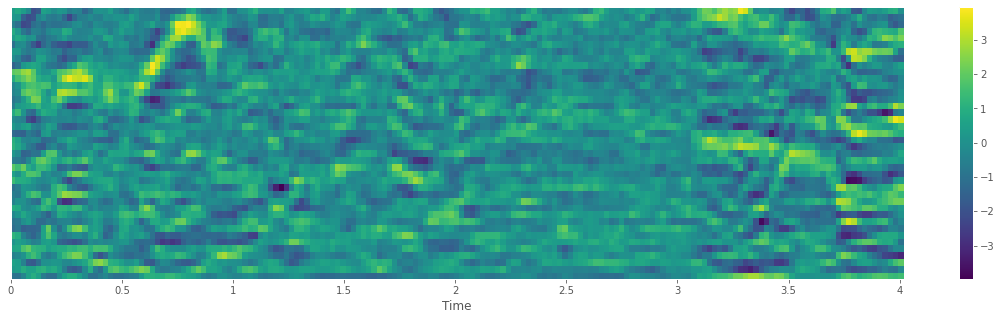

[1.0000001  1.0000001  1.         1.         1.0000001  1.0000001
 1.         0.99999994 1.0000001  1.         0.9999998  1.
 1.         0.99999994 1.         1.         0.99999994 1.
 1.         1.0000001  1.0000001  0.99999994 0.99999994 1.
 1.0000001  1.0000001  1.0000001  1.0000001  1.         1.0000001
 1.0000001  1.         1.         0.9999998  0.99999994 0.9999998
 1.         1.         1.         0.99999994]
[-1.1025136e-08  0.0000000e+00  6.8907102e-09  2.7562841e-09
  0.0000000e+00  2.2050273e-08  5.5125682e-09  1.1025136e-08
 -4.1344261e-09  5.5125682e-09 -1.3781420e-09  0.0000000e+00
 -1.1025136e-08  1.1025136e-08 -1.1025136e-08 -2.2050273e-08
 -5.5125682e-09 -2.7562841e-09  1.1025136e-08  1.1025136e-08
  0.0000000e+00 -5.5125682e-09 -5.5125682e-09  0.0000000e+00
 -1.1025136e-08 -1.1025136e-08  0.0000000e+00 -2.2050273e-08
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -5.5125682e-09
 -4.1344261e-09  1.1025136e-08 -5.5125682e-09 -5.5125682e-09
  7.5797812e-09 -8.2688523e-09

In [ ]:
# mfccs = extract_feature(examplePath)
# plt.figure(figsize=(20,5))
# librosa.display.specshow(mfccs, sr=22050, x_axis='time', cmap='viridis')
# plt.colorbar()
# plt.show()
# print (mfccs.var(axis=1))
# print (mfccs.mean(axis=1))
